In [69]:
import cv2, collections
import numpy as np
import matplotlib.pyplot as plt
import math
# import seaborn as sns
from queue import Queue
import sys
import random
sys.setrecursionlimit(1000000)

In [83]:
vidObj = cv2.VideoCapture("../images/2/video.avi")
count = 0
success = 1
sec = 0
while success:
    vidObj.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    success, image = vidObj.read()
    if success == 1:
        cv2.imwrite("../images/2/frames/frame%d.jpg" % count, image)
    count += 1
    sec += 0.1

In [78]:
# takes position(i,j), visited matrix, motion vector matrix and threshold on vector magnitude
def bfs(i, j, vis, mag, t, region):
    util = [-1, 0, 1]
    if mag[i][j] < t or vis[i][j] == True:
        return 0
    q = collections.deque()
    area = 0
    vis[i][j] = True
    q.append([i,j])
    while len(q) > 0:
        curX, curY = q.popleft()
        region[curX][curY] = 255
        area += 1
        for a in range(3):
            for b in range(3):
                x = curX + util[a]
                y = curY + util[b]
                if x >= 0 and y >= 0 and x < mag.shape[0] and y < mag.shape[1] and vis[x][y] != True:
                    vis[x][y] = True  
                    if mag[x][y] >= t:
                        q.append([x, y])
    return area

In [72]:
# to color different segmented objects
def color_it(img1,c):
    img=np.zeros((img1.shape[0],img1.shape[1]))
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            if img1[i][j] in c:
                img[i][j]=255
    return img

In [73]:
# to count the area of components
def dfs(i,j,img,re,vis,c):
    if(i<0 or i>=img.shape[0] or j<0 or j>=img.shape[1] or vis[i][j]==1 or img[i][j]==0):
        return 0
    else:
        vis[i][j] = 1
        re[i][j] = c
        val = 1
        if img[i][j] != 0:
            val += dfs(i+1,j,img,re,vis,c)
            val += dfs(i-1,j,img,re,vis,c)
            val += dfs(i,j+1,img,re,vis,c)
            val += dfs(i,j-1,img,re,vis,c)
            val += dfs(i+1,j+1,img,re,vis,c)
            val += dfs(i-1,j-1,img,re,vis,c)
            val += dfs(i-1,j+1,img,re,vis,c)
            val += dfs(i+1,j-1,img,re,vis,c)
        return val

In [74]:
# to find the area
def count_obj(img,co=255):
    count = 1
    area = []
    re = np.zeros((img.shape[0],img.shape[1]))
    visit = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if visit[i][j]==0 and img[i][j]==co:
                temp=[]
                temp.append(dfs(i,j,img,re,visit,count))
                temp.append(count-1)
                area.append(temp)
                count += 1
    return area,re

In [75]:
# calculating centroid of image 
def centroid_bfs(img,r,c,col,vis):
    h,w = img.shape
    q = Queue()
    q.put((r,c))
    vis[r,c] = 1
    cent_x = 0
    cent_y = 0
    cnt = 0
    min_x = h+1
    min_y = w+1
    max_x = 0
    max_y = 0
    while not q.empty():
        r, c = q.get()
        min_x = min(min_x,r)
        min_y = min(min_y,c)
        max_x = max(max_x,r)
        max_y = max(max_y,c)
        cnt += 1
        cent_x += r
        cent_y += c
        if r-1>=0 and vis[r-1,c] == 0 and img[r-1,c]!=0:
            vis[r-1,c] = col
            q.put((r-1,c))
        if r+1<h and vis[r+1,c] == 0 and img[r+1,c]!=0:
            vis[r+1,c] = 1
            q.put((r+1,c))
        if c-1>=0 and vis[r,c-1] == 0 and img[r,c-1]!=0:
            vis[r,c-1] = 1
            q.put((r,c-1))
        if c+1<w and vis[r,c+1] == 0 and img[r,c+1]!=0:
            vis[r,c+1] = 1
            q.put((r,c+1))
            
    cent_x = cent_x//cnt
    cent_y = cent_y//cnt
    
    # bounding box co-ordinates are pushed in an array
    arr = [(min_x,min_y),(min_x,max_y),(max_x,min_y),(max_x,max_y)]
    
    return cent_x, cent_y, arr

In [98]:
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)
first_frame = cv2.imread("../images/2/frames/frame0.jpg")
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
prev = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

# flags used for counting
in_below_100 = 0
in_above_100 = 0
out_above_170 = 0
out_below_170 = 0
# variables used for counting
in_person = 0
out_person = 0

for index in range(1,50):
    frame = cv2.imread("../images/2/frames/frame"+ str(index)+".jpg")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    prev = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

    # motion estimation
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 1, 5, 2, 5, 1.1, None)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    prev_gray = gray.copy()

    # considering only vertical motion
    vertical = mag.copy()
    for i in range(mag.shape[0]):
        for j in range(mag.shape[1]):
            vertical[i][j] = mag[i][j] * abs(np.sin(ang[i][j]))

    # calculating varying T
    ind = 0
    temp_array = [0]*(vertical.shape[0]*vertical.shape[1])
    for i in range(vertical.shape[0]):
        for j in range(vertical.shape[1]):
            temp_array[ind] = vertical[i][j]
            ind += 1
    temp_array = np.array(temp_array)
    temp_array = np.sort(temp_array)[::-1]
    # top 5%
    percent = (2*mag.shape[0]*mag.shape[1])/100
    percent = int(percent)
    T = temp_array[percent-1]
    if T < 2:
        T = 100

    # Calculating feature value M
    dy, dx = np.gradient(gray)
    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy
    R_score = np.array(gray.copy(),dtype=np.float64)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            sum_Ix = 0
            sum_Iy = 0
            sum_Ixy = 0
            for k in range(-2,3):
                for l in range(-2,3):
                    if i+k >= 0 and j+l >= 0 and i+k < gray.shape[0] and j+l < gray.shape[1]:
                        sum_Ix += Ixx[i+k][j+l]
                        sum_Iy += Iyy[i+k][j+l]
                        sum_Ixy += Ixy[i+k][j+l]
                    else:
                        sum_Ix += 0
                        sum_Iy += 0
                        sum_Ixy += 0
            det = sum_Ix*sum_Iy - sum_Ixy*sum_Ixy
            trace = sum_Ixy + sum_Ixy
            r = det - 0.05*(trace**2)
            R_score[i][j] = r 
    min_val = np.min(R_score)
    R_score += (-1)*min_val
    max_val = np.max(R_score)
    R_score = (R_score/max_val)*255
    R_score = R_score.astype(int)
    
    # choosing top_features
    listOfFeatures = []
    listTemp = []
    for x in range(frame.shape[0]):
        for y in range(frame.shape[1]):
            listTemp.append([R_score[x][y], x, y])
    listTemp.sort()
    listTemp.reverse()
    for x in range(len(listTemp)):
        listOfFeatures.append(listTemp[x])
    
    # region growing
    region = np.zeros((frame.shape[0], frame.shape[1]), dtype=int)
    vis = [[False for x in range(frame.shape[1])] for y in range(frame.shape[0])]
    for point in listOfFeatures:
        if vis[point[1]][point[2]] == False:
            area = bfs(point[1], point[2], vis, vertical, T, region)

    # component labelling
    img_gray = region.copy()
    area,re = count_obj(img_gray,255)
    thresh1 = 50
    ids=[]
    for i in area:
        if i[0] > thresh1:
            ids.append(i[1]+1)
    imgc = color_it(re,ids)
    imgc[imgc>0] = 255
    thresh2 = 3000
    img_d=cv2.dilate(imgc,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)),iterations=5)
    area,re=count_obj(img_d,255)
    ids=[]
    for i in area:
        if i[0] > thresh2:
            ids.append(i[1]+1)
    imgc = color_it(re,ids)
    imgc[imgc>0] = 255
    thresh3 = 5000
    img_d=cv2.dilate(imgc,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)),iterations=3)
    area,re=count_obj(img_d,255)
    ids=[]
    for i in area:
        if i[0] > thresh3:
            ids.append(i[1]+1)
    imgc = color_it(re,ids)
    imgc[imgc>0] = 255

    # calculating centroid
    centroid = []
    vis = np.zeros(imgc.shape)
    h, w= imgc.shape
    for i in range(h):
        for j in range(w):
            if imgc[i,j] == 255 and vis[i,j] == 0:
                # the cent_x and cent_y has x,y coordinate of centroid and the array arr has the bounding box coordinate                
                cent_x, cent_y, arr = centroid_bfs(imgc,i,j,1,vis)
                centroid.append((cent_x,cent_y,arr))
    
    # counting people
    # if len(centroid) == 0:
    #     if out_below_170 == 1:
    #         out_person += 1
    #         out_below_170 = 0
    #     if in_above_100 == 1:
    #         in_above_100 = 0
    #         in_person += 1
    for j in range(len(centroid)):
        x = centroid[j][0]
        y = centroid[j][1]
        if x < 100:
            if out_below_170 == 1:
                out_person += 1
                out_below_170 = 0
            elif out_below_170 == 0:
                in_below_100 = 1
                out_above_170 = 0
        elif x > 100 and x < 170:
            if in_below_100 == 1:
                in_below_100 = 0
                in_above_100 = 1
            elif out_above_170 == 1:
                out_above_170 = 0
                out_below_170 = 1
        elif x > 170 :
            if in_above_100 == 1:
                in_above_100 = 0
                in_person += 1
            elif in_above_100 == 0:
                out_above_170 = 1
                in_below_100 = 0
    print(index,"  in-person count-  " ,in_person, "out-person count-  " ,out_person)
    print(in_below_100, in_above_100, out_below_170, out_above_170)

1   in-person count-   0 out-person count-   0
0 0 0 0
2   in-person count-   0 out-person count-   0
1 0 0 0
3   in-person count-   0 out-person count-   0
1 0 0 0
4   in-person count-   0 out-person count-   0
1 0 0 0
5   in-person count-   0 out-person count-   0
1 0 0 0
6   in-person count-   0 out-person count-   0
0 0 0 1
7   in-person count-   0 out-person count-   0
0 0 0 1
8   in-person count-   0 out-person count-   0
0 0 0 1
9   in-person count-   0 out-person count-   0
0 0 0 1
10   in-person count-   0 out-person count-   0
0 0 0 1
11   in-person count-   0 out-person count-   0
1 0 0 0
12   in-person count-   0 out-person count-   0
1 0 0 0
13   in-person count-   0 out-person count-   0
1 0 0 0
14   in-person count-   0 out-person count-   0
1 0 0 0
15   in-person count-   0 out-person count-   0
1 0 0 0
16   in-person count-   0 out-person count-   0
1 0 0 0
17   in-person count-   0 out-person count-   0
1 0 0 0
18   in-person count-   0 out-person count-   0
1 0 0 0
1

KeyboardInterrupt: 

In [95]:
index =29

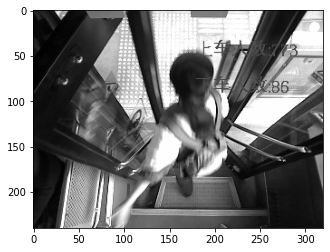

In [96]:
frame = cv2.imread("../images/2/frames/frame"+ str(index)+".jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")